In [ ]:
j = 0
x = None
codes = []
return_mat = np.zeros((11602, 1271))
j = 0
for i in code_shares:
    price_matrix= sp_data[i].astype('float')
    price_matrix = np.array(price_matrix)
    returns = np.log(price_matrix[1:]) - np.log(price_matrix[0:-1])
    if np.where(returns<-5)[0].shape[0] == 0:
        codes.append(i)
        returns[np.isnan(returns)]=-5
        return_mat[:, j] = returns
        j += 1
df_return = pd.DataFrame(data=return_mat, columns=codes)
df_return.to_csv('returns127.csv')

ffdata = pd.read_csv('./FF_Factors_daily.csv')
start_date = 19750102
end_date = 20201231
mask = (ffdata['date'] >= start_date) & (ffdata['date'] <= end_date)
ffdata = ffdata.loc[mask]
ffdata.to_csv('ffdata_11062.csv')

In [290]:
import os
import json
import mgarch
import math
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt import solvers
solvers.options['show_progress'] = False


def load_json(path):
    with open(path, 'rb') as f:
        json_dict = json.load(f)
    return json_dict


def find_first_800(sp_data_matrix, num):
    posts = []
    trading_days = sp_data_matrix.shape[0]
    for i in range(trading_days):
        num_eff = np.sum(sp_data_matrix[i, 2:]>-5)
        if num_eff == num:
            posts.append(i)
    return posts[0]


def get_sub_mat(df_return, st_idx, code_shares, sp_data, sam_size):
    indx_length = sam_size
    num_lim = indx_length + 21
    ed_idx = st_idx + num_lim
    code_ls = list(df_return.columns)[1:]
    code_used = []
    res_mat = []
    res_dict = {}
    res_pre_dict = {}
    market_cap_dict = {}
    for code_i in code_ls:
        res = df_return[code_i][st_idx:ed_idx]
        eff_num = np.sum(res>-5)
        if eff_num == num_lim:
            cap_i = code_shares[code_i] * sp_data[code_i][st_idx+indx_length]# error: -1
            res_ls  = list(res)
            res_mat.append(res_ls[0:indx_length])
            code_used.append(code_i)
            res_dict[code_i] = res_ls[0:indx_length]
            res_pre_dict[code_i] = res_ls[indx_length:indx_length+21]
            market_cap_dict[code_i] = cap_i
    return res_mat, code_used, res_dict, res_pre_dict, market_cap_dict


def get_N(res_mat, code_used, res_dict, res_pre_dict, market_cap_dict, N):
    pos = np.where(np.corrcoef(np.array(res_mat))>0.95)
    if len(pos)>1:
        line_num, row_num = pos
        line_num = line_num.tolist()
        row_num = row_num.tolist()
        code_used_ori = copy.deepcopy(code_used)
        code_used = set(code_used)
        for i in range(len(line_num)):
            for j in range(len(row_num)):
                if  i > j:
                    stock_i = code_used_ori[line_num[i]]
                    stock_j = code_used_ori[row_num[j]]
                    cap_i = market_cap_dict[stock_i]
                    cap_j = market_cap_dict[stock_j]
            
                    if  cap_i>=cap_j and cap_i in code_used:
                        code_used.remove(stock_j)
                    elif cap_i<cap_j and cap_i in code_used:
                        code_used.remove(stock_i)
    
    code_cap = {}
    for code_i in code_used:
        code_cap[code_i] =  market_cap_dict[code_i]
        
    code_cap_sorted = sorted(code_cap.items(), key=lambda x: x[1], reverse=True)
    code_N = [i[0] for i in code_cap_sorted[0:N]]
    
    res_mat_new = []
    res_pre_new = []
    for code_i in code_N:
        res_mat_new.append(res_dict[code_i])
        res_pre_new.append(res_pre_dict[code_i])
    return res_mat_new, res_pre_new


def get_rolls(code_shares, sp_data, df_return, last_num, N, num, sam_size):
    st_id = find_first_800(df_return.to_numpy(), num)
    roll_len = sam_size+21
    j = 0
    all_rolls_res = 1
    while st_id+sam_size+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                st_id, code_shares, sp_data, sam_size)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        res_mat_new = np.array(res_mat_new).transpose()
        res_pre_new = np.array(res_pre_new).transpose()
        res_all = np.vstack((res_mat_new, res_pre_new))
        st_id += 21
        if all_rolls_res is  1:
            all_rolls_res = res_all
        else:
            all_rolls_res = np.vstack((all_rolls_res, res_all))
        
    return all_rolls_res


def get_return(weights, res_pre):
    weights = np.matrix(weights)
    res_pre = np.matrix(res_pre)
    return (weights*res_pre).tolist()[0]
    

def average_weights(n):
    return np.matrix([1/n for i in range(n)])


def get_ws_cov(cov, no_short=True):
    if no_short:
        N = cov.shape[0]
        P = matrix(cov)
        q = matrix(np.zeros((N, 1)))
        G  = matrix(-np.identity(N))
        h = matrix(np.zeros((N, 1)))
        A = matrix(1.0, (1, N))
        b = matrix(1.0)
        sol = solvers.qp(P, q, G, h, A, b)
        ws = np.matrix(sol['x']).T
    else:
        cov_mat = np.matrix(cov)
        N = cov_mat.shape[0]
        I = np.matrix(np.ones(N)).T
        ws = (cov_mat.I * I)/(I.T*cov_mat.I*I)
        ws = ws.T
    return ws


def get_sam_res1(code_shares, sp_data, df_return, last_num, N, num, sam_size):
    st_id = find_first_800(df_return.to_numpy(), num)
    res_ew = []
    res_sample_cov = []
    while st_id + sam_size+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                                st_id, code_shares, sp_data, sam_size)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        st_id += 21
        avg_ws = average_weights(N)
        avg_res_i = get_return(avg_ws, res_pre_new)
        res_ew += avg_res_i
        sam_cov = np.cov(np.array(res_mat_new))
        samp_ws = get_ws_cov(sam_cov, no_short=False)
        sam_res_i = get_return(samp_ws,  res_pre_new)
        res_sample_cov += sam_res_i
    return res_ew, res_sample_cov



def get_gm(res_mat1, N):
    n_ew = int(N/5)
    gm = np.exp(np.mean(np.log(res_mat1[-252:-21, :]+math.e), axis=0))-math.e
    gm_sorted = sorted(gm, reverse=1)
    ws_ew = np.zeros_like(gm)
    ws_ew[np.where(gm>=gm_sorted[n_ew-1])] = 1/n_ew
    b = np.sum(ws_ew * gm)
    gm = np.reshape(gm, (N, 1))
    return b, gm


def get_mk_ew(res_mat1, N):
    n_ew = int(N/5)
    gm = np.exp(np.mean(np.log(res_mat1[-252:-21, :]+math.e), axis=0))-math.e
    gm_sorted = sorted(gm, reverse=1)
    ws_ew = np.zeros_like(gm)
    ws_ew[np.where(gm>=gm_sorted[n_ew-1])] = 1/n_ew
    ws_ew = np.reshape(ws_ew, (N, 1))
    return ws_ew.T


def markowitz_ws(cov_mat, res_mat1, N):
    b, ms = get_gm(res_mat1, N)
    N = cov_mat.shape[0]
    I = np.ones((N, 1))
    cov_mat = np.matrix(cov_mat)
    ms = np.matrix(ms)
    I = np.matrix(I)
    bs = np.tile(b, (N, 1)) 
    A = I.T * cov_mat.I * I
    B = I.T * cov_mat.I * ms
    C = ms.T * cov_mat.I * ms
    c1 = (C - b*B)/(A*C - B*B)
    c2 = (b*A - B)/(A*C - B*B)
    ws = c1[0,0] * (cov_mat.I * I) + c2[0,0] * (cov_mat.I * ms)
    return ws.T


def indicators(res):
    AV= round(np.mean(res)*252*100, 5)
    SD = round(np.cov(res)**0.5*252**0.5*100, 5)
    IR = round(AV/SD, 5)
    return AV, SD, IR


def read_dcc_res(path):
    res_dccnl = pd.read_csv(path)
    res_dccnl= res_dccnl['x']
    res_dccnl = list(res_dccnl)
    return res_dccnl


def res_line(res):
    portfolio_res = [1]
    a = 1
    for i in res:
        a = a*(1+i)
        portfolio_res.append(a)
    return portfolio_res


def get_hold_ws(ws1, res_mat_pre):
    ws11 = np.multiply(ws1, (1+np.sum(res_mat_pre, axis=1)))
    ws11 = ws11/np.sum(ws11)
    return ws11.tolist()[0]


def indicators2(set_ws, hold_ws):
    set_ws = np.array(set_ws)
    hold_ws = np.array(hold_ws)
    ws_change = set_ws[1:, :] - hold_ws[0:-1, :]
    TO = round(np.mean(np.linalg.norm(ws_change, ord=1, axis=1)), 4)
    GL = round(np.mean(np.linalg.norm(set_ws, ord=1, axis=1)), 4)
    PL = round(np.mean(set_ws<0), 4)
    return TO, GL, PL


def get_ew_res(rolls, N, markowitz=False):
    rtns_ew = []
    hold_ws = []
    set_ws = []
    for i in range(190):
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        if markowitz:
            ws_i = get_mk_ew(res_mat, N)
        else:
            ws_i = average_weights(N)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        rtns_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        set_ws.append(ws_i.tolist()[0])
        hold_ws.append(hold_ws_i)
        rtns_ew += rtns_i
    return rtns_ew, set_ws, hold_ws


def get_sam_res(rolls, N, markowitz=False):
    rtns_sam = []
    hold_ws = []
    set_ws = []
    for i in range(190):
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(cov_mat, res_mat, N)
        else:
            ws_i = get_ws_cov(cov_mat, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        rtns_sam_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        rtns_sam += rtns_sam_i
    return rtns_sam, set_ws, hold_ws


def get_dcc_res(root_dir, rolls, N, markowitz=False):
    file_ls = os.listdir(root_dir)
    length = len(file_ls)
    res_dccnl = []
    hold_ws = []
    set_ws = []
    for i in range(length):
        file_path = os.path.join(root_dir, '{}.csv'.format(i+1))
        cov_mat = pd.read_csv(file_path)
        cov_mat = np.matrix(cov_mat.to_numpy())
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(cov_mat, res_mat, N)
        else:
            ws_i = get_ws_cov(cov_mat, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        res_dccnl += res_i
    return res_dccnl, set_ws, hold_ws


def get_rtns_static5(rolls, N, resid5, param5, ff5_cov, markowitz=False):
    rtns_static = []
    hold_ws = []
    set_ws = []
    for i in range(190):
        resid_i = resid5[i*500:i*500+N, :]
        cov_i = np.cov(resid_i)
        cov_i = np.diag(np.diag(cov_i))
        #cov_i[np.where(abs(cov_i)<1e-7)]=0.0
        param5_i = param5[i*500:i*500+N, :]
        ff_vol_i = ff5_cov[i*5:i*5+5, :]
        cov_i = np.matrix(cov_i)
        param5_i = np.matrix(param5_i)
        ff_vol_i = np.matrix(ff_vol_i)
        rtn_cov_i =  param5_i * ff_vol_i * param5_i.T + cov_i
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(rtn_cov_i, res_mat, N)
        else:
            ws_i = get_ws_cov(rtn_cov_i, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        rtns_static += res_i
    return rtns_static, set_ws, hold_ws


def get_rtns_static1(rolls, N, resid1, param1, ff1_cov, markowitz=False):
    rtns_static = []
    hold_ws = []
    set_ws = []
    for i in range(190):
        resid_i = resid1[i*500:i*500+N, :]
        cov_i = np.cov(resid_i)
        cov_i = np.diag(np.diag(cov_i))
        #cov_i[np.where(abs(cov_i)<1e-7)]=0.0
        param1_i = param1[i*500:i*500+N, :]
        ff_vol_i = ff1_cov[i, :]
        cov_i = np.matrix(cov_i)
        param1_i = np.matrix(param1_i)
        ff_vol_i = np.matrix(ff_vol_i)
        rtn_cov_i =  param1_i * ff_vol_i * param1_i.T + cov_i
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(rtn_cov_i, res_mat, N)
        else:
            ws_i = get_ws_cov(rtn_cov_i, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        rtns_static += res_i
    return rtns_static, set_ws, hold_ws


def get_rtns_dcc_ff5(root_dir, rolls, N, param5, ff5_cov, markowitz=False):
    file_ls = os.listdir(root_dir)
    length = len(file_ls)
    res_dccnl = []
    hold_ws = []
    set_ws = []
    for i in range(length):
        file_path = os.path.join(root_dir, '{}.csv'.format(i+1))
        resid_cov = pd.read_csv(file_path)
        resid_cov = np.matrix(resid_cov.to_numpy())
        param5_i = param5[i*500:i*500+N, :]
        ff_vol_i = ff5_cov[i*5:i*5+5, :]
        param5_i = np.matrix(param5_i)
        ff_vol_i = np.matrix(ff_vol_i)
        rtn_cov_i =  param5_i * ff_vol_i * param5_i.T + resid_cov
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(rtn_cov_i, res_mat, N)
        else:
            ws_i = get_ws_cov(rtn_cov_i, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        res_dccnl += res_i
    return res_dccnl, set_ws, hold_ws


def get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff1_cov, markowitz=False):
    file_ls = os.listdir(root_dir)
    length = len(file_ls)
    res_dccnl = []
    hold_ws = []
    set_ws = []
    for i in range(length):
        file_path = os.path.join(root_dir, '{}.csv'.format(i+1))
        resid_cov = pd.read_csv(file_path)
        resid_cov = np.matrix(resid_cov.to_numpy())
        #resid_cov = np.diag(np.diag(resid_cov))
        param1_i = param1[i*500:i*500+N, :]
        ff_vol_i = ff1_cov[i, :]
        resid_cov = np.matrix(resid_cov)
        param5_i = np.matrix(param1_i)
        ff_vol_i = np.matrix(ff_vol_i)
        rtn_cov_i =  param1_i * ff_vol_i * param1_i.T + resid_cov
        st_idx = i*1281
        ed_idx = i*1281+1260
        res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        if markowitz:
            ws_i = markowitz_ws(rtn_cov_i, res_mat, N)
        else:
            ws_i = get_ws_cov(rtn_cov_i, no_short=False)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        hold_ws_i = get_hold_ws(ws_i, res_pre_i)
        hold_ws.append(hold_ws_i)
        set_ws.append(ws_i.tolist()[0])
        res_dccnl += res_i
    return res_dccnl, set_ws, hold_ws

# 1 load_data and get return rates

In [3]:
code_shares = load_json('./code_shares.json')
sp_data = pd.read_csv('./SP1273_19750103_20201231.csv')
df_return = pd.read_csv('./returns1271.csv')

# 2 get all rolling res data

In [ ]:
all_rolls_res = get_rolls(code_shares, sp_data, df_return, 11602, 500, 800, 630)

In [315]:
all_rolls_res1 = np.around(all_rolls_res, decimals=6, out=None)
col_names = []
for i in range(500):
    col_names.append('asset{}'.format(i))
df_rolls = pd.DataFrame(data=all_rolls_res1, columns=col_names)
df_rolls.to_csv('df_rolls_500_630.csv')

# 3 get portfolio universe

In [2]:
rolls = pd.read_csv('./df_rolls.csv')
rolls = rolls.to_numpy()

# 4 structure free models

# N=100

In [281]:
N = 100
root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_100, set_ws_dcc_100,  hold_ws_dcc_100 = get_dcc_res(root_dir, rolls, N)
idx1_dcc_100 = indicators(rtns_dcc_100)
idx2_dcc_100 = indicators2(set_ws_dcc_100, hold_ws_dcc_100)

rtns_ew_100, set_ws_ew_100, hold_ws_ew_100 = get_ew_res(rolls, N)
idx1_ew_100 = indicators(rtns_ew_100)
idx2_ew_100 = indicators2(set_ws_ew_100, hold_ws_ew_100)

rtns_sam_100,  set_ws_sam_100, hold_ws_sam_100 = get_sam_res(rolls, N)
idx1_sam_100 = indicators(rtns_sam_100)
idx2_sam_100 = indicators2(set_ws_sam_100, hold_ws_sam_100)

In [282]:
print('idicators1', ('AV','SD','IR'))
print('EW_100', idx1_ew_100)
print('Sample_100', idx1_sam_100)
print('DCCNL_100',idx1_dcc_100)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_100', idx2_ew_100)
print('Sample_100', idx2_sam_100)
print('DCCNL_100',idx2_dcc_100)

idicators1 ('AV', 'SD', 'IR')
EW_100 (5.19047, 20.65605, 0.25128)
Sample_100 (38.45129, 132.29348, 0.29065)
DCCNL_100 (7.42985, 13.78978, 0.53879)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_100 (0.9906, 1.0, 0.0)
Sample_100 (444.9632, 441.713, 0.4336)
DCCNL_100 (40.2612, 39.7631, 0.4646)


In [279]:
N = 100

rtns_ew_mk_100, set_ws_ew_mk_100, hold_ws_mk_ew_100 = get_ew_res(rolls, N, markowitz=True)
idx1_ew_mk_100 = indicators(rtns_ew_mk_100)
idx2_ew_mk_100 = indicators2(set_ws_ew_mk_100, hold_ws_mk_ew_100)


rtns_sam_mk_100,  set_ws_sam_mk_100, hold_ws_sam_mk_100 = get_sam_res(rolls, N, markowitz=True)
idx1_sam_mk_100 = indicators(rtns_sam_mk_100)
idx2_sam_mk_100 = indicators2(set_ws_sam_mk_100, hold_ws_sam_mk_100)

root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_mk_100, set_ws_dcc_mk_100,  hold_ws_dcc_mk_100 = get_dcc_res(root_dir, rolls, N, markowitz=True)
idx1_dcc_mk_100 = indicators(rtns_dcc_mk_100)
idx2_dcc_mk_100 = indicators2(set_ws_dcc_mk_100, hold_ws_dcc_mk_100)

In [292]:
print('idicators1', ('AV','SD','IR'))
print('EW_mk_100', idx1_ew_mk_100)
print('Sample_mk_100', idx1_sam_mk_100)
print('DCCNL_mk_100',idx1_dcc_mk_100)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_mk_100', idx2_ew_mk_100)
print('Sample_mk_100', idx2_sam_mk_100)
print('DCCNL_mk_100',idx2_dcc_mk_100)

idicators1 ('AV', 'SD', 'IR')
EW_mk_100 (6.20337, 23.09823, 0.26856)
Sample_mk_100 (694.77633, 3039.42756, 0.22859)
DCCNL_mk_100 (10.72681, 15.27598, 0.7022)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_mk_100 (1.0035, 1.0, 0.0)
Sample_mk_100 (1260.9572, 1248.8877, 0.4388)
DCCNL_mk_100 (74.2526, 73.2516, 0.4687)


# N = 200

In [283]:
N = 200
root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_200, set_ws_dcc_200,  hold_ws_dcc_200 = get_dcc_res(root_dir, rolls, N)
idx1_dcc_200 = indicators(rtns_dcc_200)
idx2_dcc_200 = indicators2(set_ws_dcc_200, hold_ws_dcc_200)

rtns_ew_200, set_ws_ew_200, hold_ws_ew_200 = get_ew_res(rolls, N)
idx1_ew_200 = indicators(rtns_ew_200)
idx2_ew_200 = indicators2(set_ws_ew_200, hold_ws_ew_200)

rtns_sam_200,  set_ws_sam_200, hold_ws_sam_200 = get_sam_res(rolls, N)
idx1_sam_200 = indicators(rtns_sam_200)
idx2_sam_200 = indicators2(set_ws_sam_200, hold_ws_sam_200)


In [284]:
print('idicators1', ('AV','SD','IR'))
print('EW_200', idx1_ew_200)
print('Sample_200', idx1_sam_200)
print('DCCNL_200',idx1_dcc_200)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_200', idx2_ew_200)
print('Sample_200', idx2_sam_200)
print('DCCNL_200',idx2_dcc_200)


idicators1 ('AV', 'SD', 'IR')
EW_200 (5.58736, 20.94381, 0.26678)
Sample_200 (-15.82624, 105.42171, -0.15012)
DCCNL_200 (9.77188, 12.96225, 0.75387)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_200 (0.9953, 1.0, 0.0)
Sample_200 (516.6393, 513.3177, 0.4568)
DCCNL_200 (14.6735, 14.5643, 0.4832)


In [291]:
N = 200

rtns_ew_mk_200, set_ws_ew_mk_200, hold_ws_mk_ew_200 = get_ew_res(rolls, N, markowitz=True)
idx1_ew_mk_200 = indicators(rtns_ew_mk_200)
idx2_ew_mk_200 = indicators2(set_ws_ew_mk_200, hold_ws_mk_ew_200)


rtns_sam_mk_200,  set_ws_sam_mk_200, hold_ws_sam_mk_200 = get_sam_res(rolls, N, markowitz=True)
idx1_sam_mk_200 = indicators(rtns_sam_mk_200)
idx2_sam_mk_200 = indicators2(set_ws_sam_mk_200, hold_ws_sam_mk_200)

root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_mk_200, set_ws_dcc_mk_200,  hold_ws_dcc_mk_200 = get_dcc_res(root_dir, rolls, N, markowitz=True)
idx1_dcc_mk_200 = indicators(rtns_dcc_mk_200)
idx2_dcc_mk_200 = indicators2(set_ws_dcc_mk_200, hold_ws_dcc_mk_200)


In [293]:
print('idicators1', ('AV','SD','IR'))
print('EW_mk_200', idx1_ew_mk_200)
print('Sample_mk_200', idx1_sam_mk_200)
print('DCCNL_mk_200',idx1_dcc_mk_200)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_mk_200', idx2_ew_mk_200)
print('Sample_mk_200', idx2_sam_mk_200)
print('DCCNL_mk_200',idx2_dcc_mk_200)


idicators1 ('AV', 'SD', 'IR')
EW_mk_200 (5.39638, 22.49498, 0.23989)
Sample_mk_200 (454.24308, 1973.68117, 0.23015)
DCCNL_mk_200 (12.94139, 14.11213, 0.91704)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_mk_200 (1.0021, 1.0, 0.0)
Sample_mk_200 (867.633, 861.0636, 0.4557)
DCCNL_mk_200 (18.7215, 18.5873, 0.4857)


# N=500

In [294]:
N = 500
root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_500, set_ws_dcc_500,  hold_ws_dcc_500 = get_dcc_res(root_dir, rolls, N)
idx1_dcc_500 = indicators(rtns_dcc_500)
idx2_dcc_500 = indicators2(set_ws_dcc_500, hold_ws_dcc_500)

rtns_ew_500, set_ws_ew_500, hold_ws_ew_500 = get_ew_res(rolls, N)
idx1_ew_500 = indicators(rtns_ew_500)
idx2_ew_500 = indicators2(set_ws_ew_500, hold_ws_ew_500)

rtns_sam_500,  set_ws_sam_500, hold_ws_sam_500 = get_sam_res(rolls, N)
idx1_sam_500 = indicators(rtns_sam_500)
idx2_sam_500 = indicators2(set_ws_sam_500, hold_ws_sam_500)


print('idicators1', ('AV','SD','IR'))
print('EW_500', idx1_ew_500)
print('Sample_500', idx1_sam_500)
print('DCCNL_500',idx1_dcc_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_500', idx2_ew_500)
print('Sample_500', idx2_sam_500)
print('DCCNL_500',idx2_dcc_500)

idicators1 ('AV', 'SD', 'IR')
EW_500 (6.82722, 21.95549, 0.31096)
Sample_500 (7.43941, 12.60113, 0.59038)
DCCNL_500 (8.1287, 12.13695, 0.66975)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_500 (0.9981, 1.0, 0.0)
Sample_500 (711.1294, 707.1217, 0.4707)
DCCNL_500 (51.7719, 51.4227, 0.5014)


In [295]:
N = 500

rtns_ew_mk_500, set_ws_ew_mk_500, hold_ws_mk_ew_500 = get_ew_res(rolls, N, markowitz=True)
idx1_ew_mk_500 = indicators(rtns_ew_mk_500)
idx2_ew_mk_500 = indicators2(set_ws_ew_mk_500, hold_ws_mk_ew_500)


rtns_sam_mk_500,  set_ws_sam_mk_500, hold_ws_sam_mk_500 = get_sam_res(rolls, N, markowitz=True)
idx1_sam_mk_500 = indicators(rtns_sam_mk_500)
idx2_sam_mk_500 = indicators2(set_ws_sam_mk_500, hold_ws_sam_mk_500)

root_dir = './cov_{}_dcc/'.format(N)
rtns_dcc_mk_500, set_ws_dcc_mk_500,  hold_ws_dcc_mk_500 = get_dcc_res(root_dir, rolls, N, markowitz=True)
idx1_dcc_mk_500 = indicators(rtns_dcc_mk_500)
idx2_dcc_mk_500 = indicators2(set_ws_dcc_mk_500, hold_ws_dcc_mk_500)

print('idicators1', ('AV','SD','IR'))
print('EW_mk_500', idx1_ew_mk_500)
print('Sample_mk_500', idx1_sam_mk_500)
print('DCCNL_mk_500',idx1_dcc_mk_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('EW_mk_500', idx2_ew_mk_500)
print('Sample_mk_500', idx2_sam_mk_500)
print('DCCNL_mk_500',idx2_dcc_mk_500)

idicators1 ('AV', 'SD', 'IR')
EW_mk_500 (6.39458, 22.37009, 0.28585)
Sample_mk_500 (166.08803, 697.20367, 0.23822)
DCCNL_mk_500 (11.19029, 12.99397, 0.86119)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
EW_mk_500 (1.001, 1.0, 0.0)
Sample_mk_500 (878.687, 873.5283, 0.4729)
DCCNL_mk_500 (70.5848, 70.1028, 0.5024)


# 2 static model

## 2.1 five factor model

In [296]:
resid5 = np.load('./ff_model_data_1260/residual_mat5.npy')
param5 = np.load('./ff_model_data_1260/params_mat5.npy')
ff_cov5 = np.load('./ff_model_data_1260/ff5_vol.npy')

In [298]:
N = 100
rtns_static5_100, set_ws_static5_100, hold_ws_static5_100 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5)


N = 200
rtns_static5_200, set_ws_static5_200, hold_ws_static5_200 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5)


N = 500
rtns_static5_500, set_ws_static5_500, hold_ws_static5_500 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5)

idx1_static5_100 = indicators(rtns_static5_100)
idx2_static5_100 = indicators2(set_ws_static5_100, hold_ws_static5_100)

idx1_static5_200 = indicators(rtns_static5_200)
idx2_static5_200 = indicators2(set_ws_static5_200, hold_ws_static5_200)

idx1_static5_500 = indicators(rtns_static5_500)
idx2_static5_500 = indicators2(set_ws_static5_500, hold_ws_static5_500)

In [299]:
print('idicators1', ('AV','SD','IR'))
print('static5_100', idx1_static5_100)
print('static5_200', idx1_static5_200)
print('static5_500', idx1_static5_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('static5_100', idx2_static5_100)
print('static5_200', idx2_static5_200)
print('static5_500', idx2_static5_500)

idicators1 ('AV', 'SD', 'IR')
static5_100 (9.42504, 14.6334, 0.64408)
static5_200 (10.63565, 14.81366, 0.71796)
static5_500 (10.82981, 14.39245, 0.75246)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
static5_100 (2.4852, 2.4879, 0.4195)
static5_200 (2.9295, 2.928, 0.4354)
static5_500 (3.2165, 3.2108, 0.4523)


In [301]:
N = 100
rtns_static5_mk_100, set_ws_static5_mk_100, hold_ws_static5_mk_100 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5, markowitz=True)

N = 200
rtns_static5_mk_200, set_ws_static5_mk_200, hold_ws_static5_mk_200 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5, markowitz=True)

N = 500
rtns_static5_mk_500, set_ws_static5_mk_500, hold_ws_static5_mk_500 = \
get_rtns_static5(rolls, N, resid5, param5, ff_cov5, markowitz=True)

idx1_static5_mk_100 = indicators(rtns_static5_mk_100)
idx2_static5_mk_100 = indicators2(set_ws_static5_mk_100, hold_ws_static5_mk_100)

idx1_static5_mk_200 = indicators(rtns_static5_mk_200)
idx2_static5_mk_200 = indicators2(set_ws_static5_mk_200, hold_ws_static5_mk_200)

idx1_static5_mk_500 = indicators(rtns_static5_mk_500)
idx2_static5_mk_500 = indicators2(set_ws_static5_mk_500, hold_ws_static5_mk_500)

In [302]:
print('idicators1', ('AV','SD','IR'))
print('static5_mk_100', idx1_static5_mk_100)
print('static5_mk_200', idx1_static5_mk_200)
print('static5_mk_500', idx1_static5_mk_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('static5_mk_100', idx2_static5_mk_100)
print('static5_mk_200', idx2_static5_mk_200)
print('static5_mk_500', idx2_static5_mk_500)

idicators1 ('AV', 'SD', 'IR')
static5_mk_100 (13.82901, 16.73163, 0.82652)
static5_mk_200 (14.81627, 16.63726, 0.89055)
static5_mk_500 (14.44829, 15.73275, 0.91836)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
static5_mk_100 (2.8741, 2.8768, 0.4206)
static5_mk_200 (3.2801, 3.2782, 0.4396)
static5_mk_500 (3.5296, 3.5243, 0.4548)


## 2.2 one-factor model

In [303]:
resid1 = np.load('./ff_model_data_1260/residual_mat1.npy')
param1 = np.load('./ff_model_data_1260/params_mat1.npy')
ff_cov1 = np.load('./ff_model_data_1260/ff1_vol.npy')

In [304]:
N = 100
rtns_static1_100, set_ws_static1_100, hold_ws_static1_100 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1)


N = 200
rtns_static1_200, set_ws_static1_200, hold_ws_static1_200 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1)


N = 500
rtns_static1_500, set_ws_static1_500, hold_ws_static1_500 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1)

idx1_static1_100 = indicators(rtns_static1_100)
idx2_static1_100 = indicators2(set_ws_static1_100, hold_ws_static1_100)

idx1_static1_200 = indicators(rtns_static1_200)
idx2_static1_200 = indicators2(set_ws_static1_200, hold_ws_static1_200)

idx1_static1_500 = indicators(rtns_static1_500)
idx2_static1_500 = indicators2(set_ws_static1_500, hold_ws_static1_500)

In [305]:
print('idicators1', ('AV','SD','IR'))
print('static1_100', idx1_static1_100)
print('static1_200', idx1_static1_200)
print('static1_500', idx1_static1_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('static1_100', idx2_static1_100)
print('static1_200', idx2_static1_200)
print('static1_500', idx2_static1_500)


idicators1 ('AV', 'SD', 'IR')
static1_100 (10.02253, 16.0114, 0.62596)
static1_200 (11.2105, 16.31887, 0.68697)
static1_500 (11.07083, 16.18345, 0.68408)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
static1_100 (2.2572, 2.2586, 0.4483)
static1_200 (2.403, 2.4009, 0.4619)
static1_500 (2.4481, 2.444, 0.4806)


In [306]:
N = 100
rtns_static1_mk_100, set_ws_static1_mk_100, hold_ws_static1_mk_100 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1, markowitz=True)

N = 200
rtns_static1_mk_200, set_ws_static1_mk_200, hold_ws_static1_mk_200 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1, markowitz=True)

N = 500
rtns_static1_mk_500, set_ws_static1_mk_500, hold_ws_static1_mk_500 = \
get_rtns_static1(rolls, N, resid1, param1, ff_cov1, markowitz=True)

idx1_static1_mk_100 = indicators(rtns_static1_mk_100)
idx2_static1_mk_100 = indicators2(set_ws_static1_mk_100, hold_ws_static1_mk_100)

idx1_static1_mk_200 = indicators(rtns_static1_mk_200)
idx2_static1_mk_200 = indicators2(set_ws_static1_mk_200, hold_ws_static1_mk_200)

idx1_static1_mk_500 = indicators(rtns_static1_mk_500)
idx2_static1_mk_500 = indicators2(set_ws_static1_mk_500, hold_ws_static1_mk_500)


In [307]:
print('idicators1', ('AV','SD','IR'))
print('static1_mk_100', idx1_static1_mk_100)
print('static1_mk_200', idx1_static1_mk_200)
print('static1_mk_500', idx1_static1_mk_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('static1_mk_100', idx2_static1_mk_100)
print('static1_mk_200', idx2_static1_mk_200)
print('static1_mk_500', idx2_static1_mk_500)

idicators1 ('AV', 'SD', 'IR')
static1_mk_100 (15.16303, 18.26413, 0.83021)
static1_mk_200 (16.29923, 18.3369, 0.88888)
static1_mk_500 (15.334, 17.58509, 0.87199)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
static1_mk_100 (2.6626, 2.6637, 0.4381)
static1_mk_200 (2.8051, 2.8023, 0.4436)
static1_mk_500 (2.8261, 2.8215, 0.4658)


# 3 DCC-NL approxiamate model

## 3.1 five factor model

In [308]:
param5 = np.load('./ff_model_data_1260/params_mat5.npy')
ff_cov5 = np.load('./ff_model_data_1260/ff5_vol_dcc.npy')

In [317]:
N = 100
root_dir = './ff_model_data_1260/resid_dcc_cov5_100/'
res_dccnl_ff5_100, set_ws_dccnl_ff5_100, hold_ws_dccnl_ff5_100 = \
get_rtns_dcc_ff5(root_dir, rolls, N, param5, ff_cov5)

N = 200
root_dir = './ff_model_data_1260/resid_dcc_cov5_200/'
res_dccnl_ff5_200, set_ws_dccnl_ff5_200, hold_ws_dccnl_ff5_200 = \
get_rtns_dcc_ff5(root_dir, rolls, N, param5, ff_cov5)

idx1_dccnl_ff5_100 =  indicators(res_dccnl_ff5_100)
idx2_dccnl_ff5_100 =  indicators2(set_ws_dccnl_ff5_100, hold_ws_dccnl_ff5_100)

idx1_dccnl_ff5_200 =  indicators(res_dccnl_ff5_200)
idx2_dccnl_ff5_200 =  indicators2(set_ws_dccnl_ff5_200, hold_ws_dccnl_ff5_200)

In [318]:
print('idicators1', ('AV','SD','IR'))
print('idx1_dccnl_ff5_100', idx1_dccnl_ff5_100)
print('idx1_dccnl_ff5_200', idx1_dccnl_ff5_200)
#print('idx2_dccnl_ff5_500', idx1_static1_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('idx2_dccnl_ff5_100', idx2_dccnl_ff5_100)
print('idx2_dccnl_ff5_200', idx2_dccnl_ff5_200)
#print('static1_500', idx2_static1_500)

idicators1 ('AV', 'SD', 'IR')
idx1_dccnl_ff5_100 (6.7857, 14.46385, 0.46915)
idx1_dccnl_ff5_200 (8.00029, 13.02876, 0.61405)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
idx2_dccnl_ff5_100 (630.7817, 623.7603, 0.427)
idx2_dccnl_ff5_200 (111.4408, 110.3599, 0.4569)


In [315]:
N = 100
root_dir = './ff_model_data_1260/resid_dcc_cov5_100/'
res_dccnl_ff5_mk_100, set_ws_dccnl_ff5_mk_100, hold_ws_dccnl_ff5_mk_100 = \
get_rtns_dcc_ff5(root_dir, rolls, N, param5, ff_cov5, markowitz=True)

N = 200
root_dir = './ff_model_data_1260/resid_dcc_cov5_200/'
res_dccnl_ff5_mk_200, set_ws_dccnl_ff5_mk_200, hold_ws_dccnl_ff5_mk_200 = \
get_rtns_dcc_ff5(root_dir, rolls, N, param5, ff_cov5, markowitz=True)

idx1_dccnl_ff5_mk_100 =  indicators(res_dccnl_ff5_mk_100)
idx2_dccnl_ff5_mk_100 =  indicators2(set_ws_dccnl_ff5_mk_100, hold_ws_dccnl_ff5_mk_100)

idx1_dccnl_ff5_mk_200 =  indicators(res_dccnl_ff5_mk_200)
idx2_dccnl_ff5_mk_200 =  indicators2(set_ws_dccnl_ff5_mk_200, hold_ws_dccnl_ff5_mk_200)

In [338]:
print('idicators1', ('AV','SD','IR'))
print('idx1_dccnl_ff5_mk_100', idx1_dccnl_ff5_mk_100)
print('idx1_dccnl_ff5_mk_200', idx1_dccnl_ff5_mk_200)
#print('idx2_dccnl_ff5_500', idx1_static1_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('idx2_dccnl_ff5_mk_100', idx2_dccnl_ff5_mk_100)
print('idx2_dccnl_ff5_mk_200', idx2_dccnl_ff5_mk_200)
#print('static1_500', idx2_static1_500)

idicators1 ('AV', 'SD', 'IR')
idx1_dccnl_ff5_mk_100 (9.31276, 15.62302, 0.59609)
idx1_dccnl_ff5_mk_200 (10.32662, 14.19735, 0.72736)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
idx2_dccnl_ff5_mk_100 (1156.7837, 1142.5815, 0.4403)
idx2_dccnl_ff5_mk_200 (443.5317, 439.2675, 0.4616)


# 3.2 one-factor model

In [319]:
param1 = np.load('./ff_model_data_1260/params_mat1.npy')
ff_cov1 = np.load('./ff_model_data_1260/ff1_vol_dcc.npy')

In [320]:
N = 100
root_dir = './ff_model_data_1260/resid_dcc_cov1_100/'
res_dccnl_ff1_100, set_ws_dccnl_ff1_100, hold_ws_dccnl_ff1_100 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1)

N = 200
root_dir = './ff_model_data_1260/resid_dcc_cov1_200/'
res_dccnl_ff1_200, set_ws_dccnl_ff1_200, hold_ws_dccnl_ff1_200 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1)

idx1_dccnl_ff1_100 = indicators(res_dccnl_ff1_100)
idx2_dccnl_ff1_100 = indicators2(set_ws_dccnl_ff1_100, hold_ws_dccnl_ff1_100)

idx1_dccnl_ff1_200 = indicators(res_dccnl_ff1_200)
idx2_dccnl_ff1_200 = indicators2(set_ws_dccnl_ff1_200, hold_ws_dccnl_ff1_200)

In [340]:
print('idicators1', ('AV','SD','IR'))
print('dccnl_ff1_100', idx1_dccnl_ff1_100)
print('dccnl_ff1_200', idx1_dccnl_ff1_200)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('dccnl_ff1_100', idx2_dccnl_ff1_100)
print('dccnl_ff1_200', idx2_dccnl_ff1_200)

idicators1 ('AV', 'SD', 'IR')
dccnl_ff1_100 (9.26, 13.63718, 0.67903)
dccnl_ff1_200 (10.06905, 12.38824, 0.81279)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
dccnl_ff1_100 (272.962, 268.7343, 0.4339)
dccnl_ff1_200 (254.613, 252.3522, 0.4567)


In [325]:
N = 100
root_dir = './ff_model_data_1260/resid_dcc_cov1_100/'
res_dccnl_ff1_mk_100, set_ws_dccnl_ff1_mk_100, hold_ws_dccnl_ff1_mk_100 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1, markowitz=True)

N = 200
root_dir = './ff_model_data_1260/resid_dcc_cov1_200/'
res_dccnl_ff1_mk_200, set_ws_dccnl_ff1_mk_200, hold_ws_dccnl_ff1_mk_200 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1,  markowitz=True)

idx1_dccnl_ff1_mk_100 = indicators(res_dccnl_ff1_mk_100)
idx2_dccnl_ff1_mk_100 = indicators2(set_ws_dccnl_ff1_mk_100, hold_ws_dccnl_ff1_mk_100)

idx1_dccnl_ff1_mk_200 = indicators(res_dccnl_ff1_mk_200)
idx2_dccnl_ff1_mk_200 = indicators2(set_ws_dccnl_ff1_mk_200, hold_ws_dccnl_ff1_mk_200)

In [368]:
print('idicators1', ('AV','SD','IR'))
print('idx1_dccnl_ff1_mk_100', idx1_dccnl_ff1_mk_100)
print('idx1_dccnl_ff1_mk_200', idx1_dccnl_ff1_mk_200)
#print('idx2_dccnl_ff5_500', idx1_static1_500)
print('---------------------------------')
print('idicators2', ('TO','GL','PL'))
print('idx2_dccnl_ff1_mk_100', idx2_dccnl_ff1_mk_100)
print('idx2_dccnl_ff1_mk_200', idx2_dccnl_ff1_mk_200)
#print('static1_500', idx2_static1_500)

idicators1 ('AV', 'SD', 'IR')
idx1_dccnl_ff1_mk_100 (11.8474, 15.02672, 0.78842)
idx1_dccnl_ff1_mk_200 (12.41126, 13.7344, 0.90366)
---------------------------------
idicators2 ('TO', 'GL', 'PL')
idx2_dccnl_ff1_mk_100 (617.1831, 607.4916, 0.444)
idx2_dccnl_ff1_mk_200 (422.5837, 418.611, 0.4603)


In [366]:
N = 500
root_dir = './ff_model_data_1260/resid_dcc_cov1_500/'
res_dccnl_ff1_500, set_ws_dccnl_ff1_500, hold_ws_dccnl_ff1_500 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1)

res_dccnl_ff1_mk_500, set_ws_dccnl_ff1_mk_500, hold_ws_dccnl_ff1_mk_500 = \
get_rtns_dcc_ff1(root_dir, rolls, N, param1, ff_cov1, markowitz=True)

In [373]:
length = len(res_dccnl_ff1_500)
print(indicators(res_dccnl_ff1_500))
print(indicators(res_dccnl_ff1_200[0:length]))

print(indicators(res_dccnl_ff1_mk_500))
print(indicators(res_dccnl_ff1_mk_200[0:length]))
print(indicators(rtns_static5_mk_500[0:length]))

(7.15641, 9.02222, 0.7932)
(10.79734, 11.63827, 0.92774)
(11.19995, 10.42028, 1.07482)
(13.37281, 12.84019, 1.04148)
(13.80363, 13.71157, 1.00671)


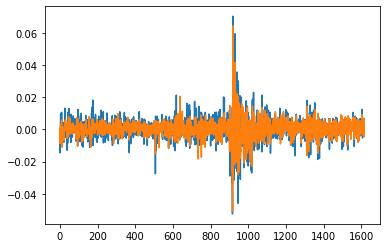

In [374]:
plt.plot((res_dccnl_ff1_200[0:len(res_dccnl_ff1_500)]))
plt.plot((res_dccnl_ff1_500))

In [372]:
len(res_dccnl_ff1_500)

1617